In [1]:
!pip install spacy
!pip install spacy-transformers
!pip install yake

import pandas as pd
import numpy as np

import torch
import spacy
import spacy_transformers

from tqdm import tqdm

import requests
from bs4 import BeautifulSoup
import re

import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
import gensim.downloader as api
from gensim.models import Word2Vec

import seaborn as sns

from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score

from collections import defaultdict

import yake

  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.2.0
    Uninstalling typing_extensions-4.2.0:
      Successfully uninstalled typing_extensions-4.2.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
tensorflow 2.6.4 requires absl-py~=0.10, but you have absl-py 1.0.0 which is incompatible.
tensorflow 2.6.4 requires numpy~=1.19.2, but you have numpy 1.21.6 which is incompatible.
tensorflow 2.6.4 requires six~=1.15.0, but you have six 1.16.0 which is incompatible.
tensorflow 2.6.4 requires wrapt~=1.12.1, but you have wrapt 1.14.1 which is incompatible.
tensorflow-transform 1.8.0 requires pyarrow<6,>=1, but you have pyarrow 8.0.0 which is incompatible.
tensorflow-transform 1.8.0 requires tensorflow!=2.0.*,!=2.1.*,!=2.2.*,!=2.3.*,!

In [2]:
pd.set_option('display.max_rows', 300)

In [3]:
#We will need spacy for text preprocessing

nlp = spacy.load("en_core_web_sm")

In [4]:
df = pd.read_csv('../input/space-news-dataset/spacenews.csv')

In [5]:
df.head()

,title,url,content,author,date,postexcerpt
0,Astrocast buying Hiber to boost funding and ex...,https://spacenews.com/astrocast-buying-hiber-t...,"TAMPA, Fla. — Cash-strapped smallsat operator ...",Jason Rainbow,"May 31, 2022",Cash-strapped smallsat operator Astrocast anno...
1,Sierra Space to partner with Spirit AeroSystem...,https://spacenews.com/sierra-space-to-partner-...,WASHINGTON — Sierra Space announced May 31 a s...,Jeff Foust,"May 31, 2022",Sierra Space announced May 31 a strategic part...
2,Rocket to launch China’s next space station mo...,https://spacenews.com/rocket-to-launch-chinas-...,HELSINKI — A Long March 5B rocket has arrived ...,Andrew Jones,"May 31, 2022",A Long March 5B rocket has arrived at Wenchang...
3,Against Quad? China launches satellite-based E...,https://spacenews.com/against-quad-china-launc...,"SEOUL, South Korea — In what appears to be a t...",Park Si-soo,"May 31, 2022",In what appears to be a tit-for-tat move again...
4,House committee questions proposed delay in NA...,https://spacenews.com/house-committee-question...,WASHINGTON — Members of the House Science Comm...,Jeff Foust,"May 31, 2022",Members of the House Science Committee used a ...


In [6]:
df.shape

(17474, 6)

In [7]:
#Check for NaN values

df.isna().sum()

title            0
url              0
content        167
author           0
date             0
postexcerpt    134
dtype: int64

In [8]:
#Obtain the indices of the dataset where the content value is NaN.

content_nan_indices = df[df['content'].isnull()].index

In [9]:
# Let's try to get the contents of the missing articles using Requests and Beautiful Soup. 
# I checked some of these, and their contents seem to be under the tablet-wrapper class.  

def get_article_content(url):
    page = requests.get(url)
    soup = BeautifulSoup(page.content, "html.parser")
    article_content = soup.find("div", class_ = "tablet-wrapper").text
    return article_content

In [10]:
#We still couldn't get some of them, but the rest look fine.

total_errors = 0

for i, u in tqdm(zip(content_nan_indices, df.loc[content_nan_indices, 'url'].values)):
    try:
        df.loc[i, 'content'] = get_article_content(u)
    except:
        #print('Error getting content from web page')
        total_errors += 1
    
print('Failed to get content for {} articles'.format(total_errors))

167it [02:43,  1.02it/s]

Failed to get content for 31 articles


In [11]:
# Let's check what we've got. 
# Note that we aren't doing any preprocessing right now; spaCy will take care of that later.

df.loc[content_nan_indices, 'content'][:15]

1023    \nRhea Space Activity will develop an autonomo...
3729                                                  NaN
3756    \n“We can’t build Orion from home."\n\n\n\n\nT...
4273    \n\n\n\n\nSAN FRANCISCO — Ursa Space Systems, ...
4575                                                  NaN
4699    \n\n\nLOGAN, Utah — Two of the largest commerc...
4785    \n\n\n\n\n\n\n\n\n\n\n\n\n \nHELSINKI — China ...
5182    \n\n\n\n\n\nSAN FRANCISCO — Morpheus Space is ...
5679                                                  NaN
5905                                                  NaN
6280    \n\n\nHELSINKI, Finland — China launched twice...
6328    \n\n\nWARSAW, Poland — The European Commission...
7000    \n\n\n\n\n\nThis article originally ran in the...
7328                                                  NaN
7906                                                  NaN
Name: content, dtype: object

In [12]:
df.isna().sum()

title            0
url              0
content         31
author           0
date             0
postexcerpt    134
dtype: int64

In [13]:
#Drop the NaNs

df.dropna(axis = 0, subset = ['content'], inplace = True)

In [14]:
#Let's do some visualizations

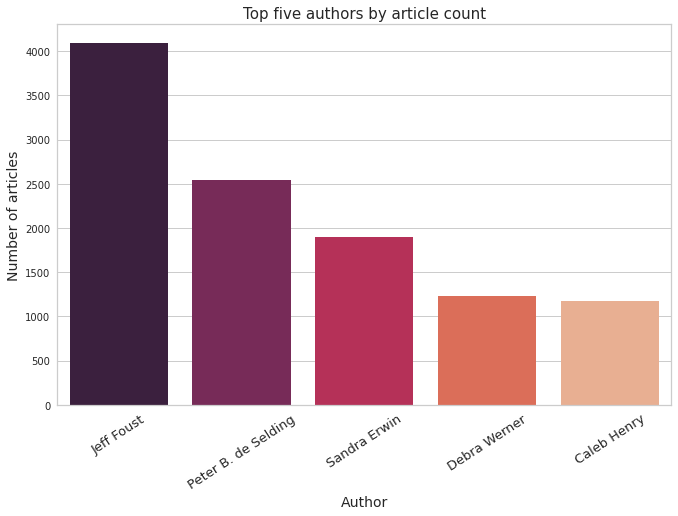

In [15]:
plt.figure(figsize = (11, 7))
sns.countplot(x = 'author', data = df, order = df['author'].value_counts()[:5].index, palette = 'rocket')
plt.xticks(size = 13, rotation = 33)
plt.xlabel('Author', size = 14)
plt.ylabel('Number of articles', size = 14)
plt.title('Top five authors by article count', size = 15)
plt.show()

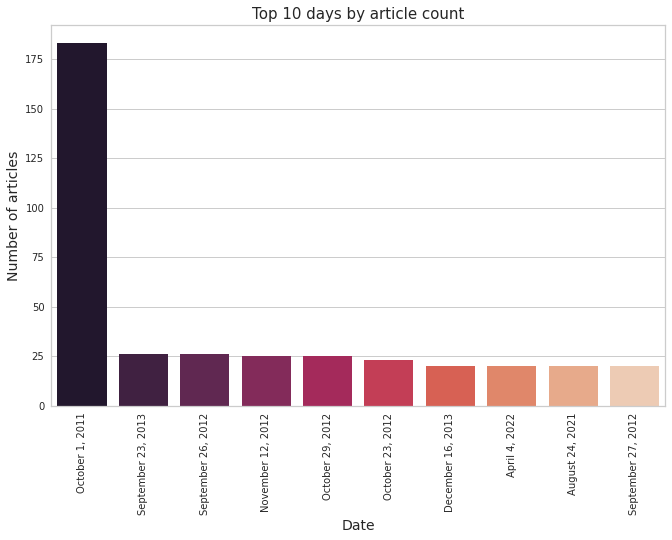

In [16]:
plt.figure(figsize = (11, 7))
sns.countplot(x = 'date', data = df, order = df['date'].value_counts()[:10].index, palette = 'rocket')
plt.xticks(size = 10, rotation = 90)
plt.xlabel('Date', size = 14)
plt.ylabel('Number of articles', size = 14)
plt.title('Top 10 days by article count', size = 15)
plt.show()

In [17]:
# It looks like there were an unusually high number of articles on October 1, 2011. 
# Let's take a look at some of these.

for i in df[df['date'] == 'October 1, 2011']['title'][:30]:
    print(i)

Shuttle Atlantis Returns from Last Scheduled Mission
Shuttle Retirement Slipping into 2011
NASA Packs Up Robot Helper for International Space Station Trip
NASA Takes Over after Japan Evacuates ISS Control Center [Discovery News]
Latest $1.5B in JWST Cost Overruns Imperils Other High-priority Projects
Satellite Imagery Provides Real-life Mountains for Snowboarding Video Game [Ars Technica]
Japan Clears H-2A Rocket for Sept. 17 Spy Sat Launch
Jody Singer, SLS Deputy Program Manager, NASA Marshall Space Flight Center
Prices Remain Stable in Resurgent Latin American Satellite Market
Falcon 9 Hardware Arrives at the Cape [Florida Today]
Boeing Should Lose $271 Million in Rocket Billings, Audit Says [Bloomberg]
Extra Shuttle Flight in Question [WFTV]
Giffords To Attend Endeavor Launch if Health Allows [The Hill]
USA Engineer Dies from Shuttle Launch Pad Fall [Orlando Sentinel]
Bolden Balks at Congressionally Designed Rocket [SpacePolicyOnline.com]
Musk Answers Doubts about Low, Low Launch Pr

In [18]:
df['article_len'] = df['content'].apply(lambda x: len(x))

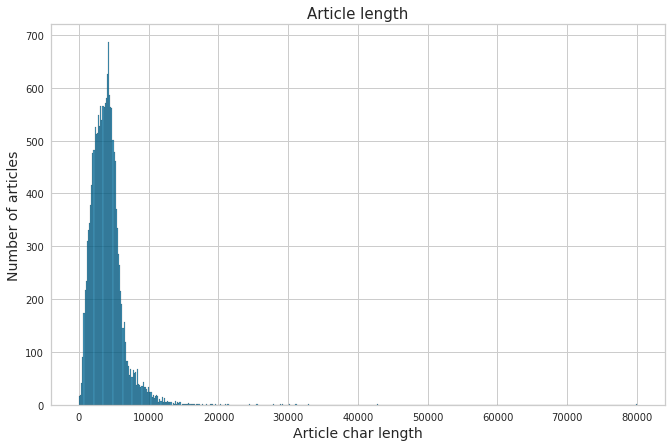

In [19]:
#We want to check if there are some distinct groups of articles based on length, like short news and longer research articles, for instance.

plt.figure(figsize = (11, 7))
sns.histplot(df['article_len'], bins = 500)
plt.xlabel('Article char length', size = 14)
plt.ylabel('Number of articles', size = 14)
plt.title('Article length', size = 15)
plt.show()

In [20]:
#Let's get an idea of what the longer articles are about. Naturally enough, they seem to be summary articles.

for i in df[df['article_len'] > 25000].sort_values(by = 'article_len', ascending = False)['title']:
    print(i, df[df['title'] == i]['article_len'].item())

The latest COVID-19 news and event updates for the global space industry 80006
SpaceNews 2015 Year in Review 42818
2011: The Year in Review 32953
2010: The Year in Review 31180
SpaceNews 2014 Year in Review 30121
The SpaceNews Awards 2021: Meet the nine winners 29138
Year Begins, Ends with Future of Human Spaceflight Up in Air 28938
The 2020 SpaceNews Awards winners 27847
2010-2019: The decade in space 25597


In [21]:
#Print the contents of N random articles from the dataset to get an idea of the text preprocessing steps

def show_random_articles(data, n = 10, seed = 42):
    np.random.seed(seed)
    random_indices = np.random.randint(0, len(data) - 1, n)
    for i in random_indices:
        print('Article index: {}'.format(i))
        print()
        print(data.loc[i, 'content'])
        print('=' * 100)

In [22]:
show_random_articles(df, 2)

Article index: 15795


 
 
 The first primary mirror segment of NASA’s James Webb Space Telescope (JWST) has been polished to its required specifications as measured at operational cryogenic temperatures, setting the stage for polishing of the telescope’s remaining 18 flight-mirror segments in preparation for launch in June 2014, NASA said in a March 2 press release. “Many predicted it would take us multiple iterations to successfully polish these mirror segments to achieve the correct optical prescription at the telescope’s operating temperatures, but we did it on our first try,” said Scott Willoughby, JWST program manager at Redondo Beach, Calif.-based  Northrop Grumman Aerospace Systems , which is leading the observatory’s design and development for NASA’s Goddard Space Flight Center in Greenbelt, Md. “All our budgets and schedules are based on this, and it’s a confirmation of the basic plan we proposed 10 years ago.” JWST, a joint effort by NASA, the European Space Agency and the C

In [23]:
# Doing text preprocessing. I think the code is pretty self-explanatory. 
# Alternatively, you might consider adding 'ORG', 'LOC', 'TIME', 'CARDINAL', 'PERCENT', and 'QUANTITY' entity types.  

def process_content(x):
    tokenized = [str(token.lemma_).lower() for token in nlp(x) if token.pos_ != 'PROPN' and\
                 token.ent_type_ not in ['GPE', 'DATE', 'NORP', 'MONEY', 'ORDINAL', 'PERSON'] and\
                 token.is_stop == False and\
                 token.text.isalpha() == True and\
                 len(str(token.lemma_)) > 3]
    clean_str = ' '.join(tokenized)
    return clean_str

In [24]:
df.reset_index(drop = True, inplace = True)

In [25]:
proc_content = []

for i in tqdm(range(df.shape[0])):
    proc_content.append(process_content(df.loc[i, 'content']))

100%|██████████| 17443/17443 [28:11<00:00, 10.31it/s]


In [26]:
df['content_clean'] = proc_content

In [27]:
df['content_clean'][:5]

0    cash strap operator announce plan connectivity...
1    announce strategic partnership aerospace manuf...
2    rocket arrive spaceport gear send space statio...
3    appear nation launch satellite base maritime d...
4    member hearing planetary science decadal surve...
Name: content_clean, dtype: object

In [28]:
#Check for NaNs

df.isna().sum()

title              0
url                0
content            0
author             0
date               0
postexcerpt      133
article_len        0
content_clean      0
dtype: int64

In [29]:
#In case there are any NaNs or empty strings:

df.dropna(axis = 0, subset = ['content_clean'], inplace = True)
df = df[df['content_clean'] != '']
df.reset_index(drop = True, inplace = True)

In [30]:
#Also, we have a weird one here:

df.loc[13588, :]

title            Sed Donec Curabitur Ullamcorper Condi Lorum Ipsum
url              https://spacenews.com/sed-donec-curabitur-ulla...
content          Duis ornare neque vitae turpis consequat ornar...
author                                             SpaceNews Staff
date                                                 June 13, 2012
postexcerpt      Nulla facilisi. Nulla non nisi vitae metus iac...
article_len                                                   1203
content_clean    ornare neque vita turpis consequat ornare done...
Name: 13588, dtype: object

In [31]:
#Let's get rid of it

df.drop(13588, inplace = True)

In [32]:
df.reset_index(drop = True, inplace = True)

In [33]:
#Get the weights of tf-idf vectorizer

vectorizer = TfidfVectorizer()

vectorized = vectorizer.fit_transform(df['content_clean'])

weights = dict(zip(vectorizer.get_feature_names_out(), vectorizer.idf_))

In [34]:
#Tokenize the clean content

list_split = []

for i in df['content_clean']:
    list_split.append(i.split())

In [35]:
# Train your own Word2Vec model with 100 dimensions (it works better than 300 in this case). 
# I found that it renders better results than some pre-trained models like GloVe-Wiki-GigaWord-50 or Word2Vec-Google-News-300.

w2v_model = Word2Vec(list_split, vector_size = 100, epochs = 30, window = 5, workers = 1, seed = 10)

In [36]:
print('Doc count: {}'.format(w2v_model.corpus_count))
print('Total words in corpus: {}'.format(w2v_model.corpus_total_words))

Doc count: 17434
Total words in corpus: 4085894


In [37]:
w2v_model.wv.most_similar('science')

[('scientific', 0.6919705867767334),
 ('astrophysic', 0.6461089253425598),
 ('heliophysic', 0.6432991027832031),
 ('geologist', 0.6024591326713562),
 ('scientist', 0.5654076933860779),
 ('astrobiology', 0.5636880993843079),
 ('europa', 0.558239758014679),
 ('exploration', 0.5281888842582703),
 ('astronomy', 0.510421633720398),
 ('aeronautics', 0.48696139454841614)]

In [38]:
w2v_model.wv.most_similar('satellite')

[('geostationary', 0.6884396076202393),
 ('constellation', 0.6758684515953064),
 ('geosynchronous', 0.5684892535209656),
 ('band', 0.5647974014282227),
 ('condosat', 0.5599485635757446),
 ('orbit', 0.5549192428588867),
 ('iridium', 0.5500178337097168),
 ('fleet', 0.5414356589317322),
 ('telecommunication', 0.5299381613731384),
 ('spacecraft', 0.5155335664749146)]

In [39]:
#We want to get sentence embeddings using the log of tf-idf weights multiplied by each word vector and then taking the mean of each sentence's word vectors.

def sentence_vectors(x):
    sent_vec = []
    for token in x.split():
        try:
            sent_vec.append(np.log(weights[token])*w2v_model.wv[token])
        except:
            continue
    return np.mean(sent_vec, axis = 0)

In [40]:
#Get sentence embeddings

sentences = []

for i in tqdm(range(df.shape[0])):
    sentences.append(sentence_vectors(df.loc[i, 'content_clean']))

100%|██████████| 17434/17434 [00:27<00:00, 634.61it/s]


In [41]:
df['sent'] = sentences

In [42]:
df[df['sent'].isna()]

,title,url,content,author,date,postexcerpt,article_len,content_clean,sent


In [43]:
df['sent']

0        [-0.9019428, 0.037351925, 0.26196715, -0.35836...
1        [-0.5073857, -0.2895692, 0.25624648, 0.1887589...
2        [-0.09297916, 0.059920933, -0.3073481, -0.2615...
3        [-0.3512235, 0.8825936, 0.5168351, -0.01005366...
4        [-0.813682, 0.14057629, -0.0877423, 1.5811653,...
                               ...                        
17429    [-0.0016133866, 0.049662787, 0.00842653, 0.099...
17430    [-0.07356896, -0.05683304, -0.5504059, 0.57474...
17431    [-0.3709153, 0.176385, 0.28167152, 0.84053254,...
17432    [-0.0553466, 0.11043572, -0.56933945, 0.283644...
17433    [-0.08332095, -0.12280759, 0.024174461, 0.6542...
Name: sent, Length: 17434, dtype: object

In [44]:
#Use some techniques to determine the optimal number of clusters

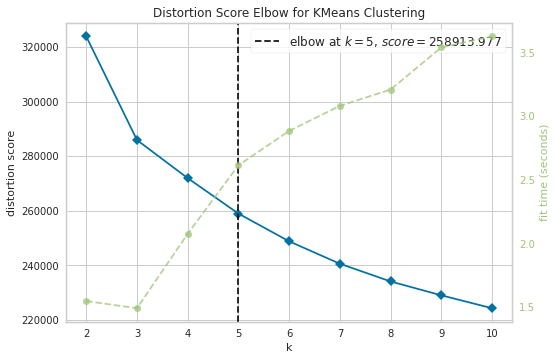

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [45]:
model = KMeans(init = 'k-means++', random_state = 18)
visualizer = KElbowVisualizer(model, k = (2, 11), timings = True)
visualizer.fit(np.array(sentences))
visualizer.show()

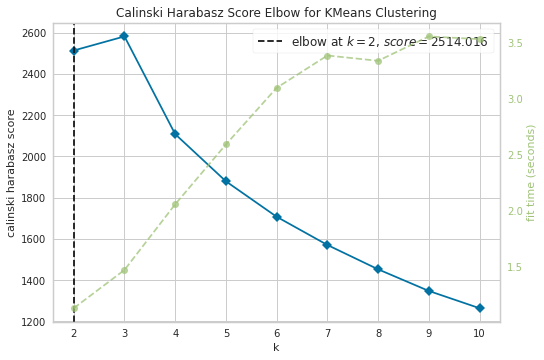

<AxesSubplot:title={'center':'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [46]:
model = KMeans(init = 'k-means++', random_state = 18)
visualizer = KElbowVisualizer(model, k = (2, 11), metric = 'calinski_harabasz', timings = True)
visualizer.fit(np.array(sentences))
visualizer.show()

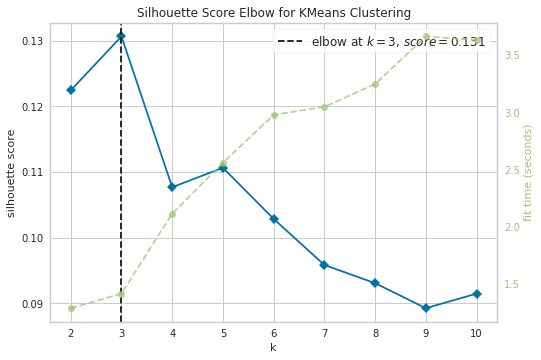

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [47]:
model = KMeans(init = 'k-means++', random_state = 18)
visualizer = KElbowVisualizer(model, k = (2, 11), metric = 'silhouette', timings = True)
visualizer.fit(np.array(sentences))
visualizer.show()

In [48]:
def get_kmeans_score(data, center):

    kmeans = KMeans(n_clusters = center, random_state = 18)
    model = kmeans.fit_predict(data)
    
    score = davies_bouldin_score(data, model)
    
    return score

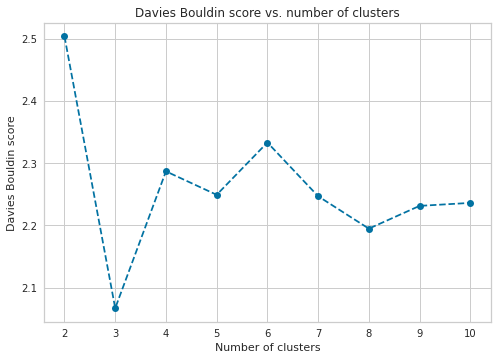

In [49]:
scores = []
centers = list(range(2, 11))

for center in centers:
    scores.append(get_kmeans_score(np.array(sentences), center))
    
plt.plot(centers, scores, linestyle = '--', marker = 'o', color = 'b');
plt.xlabel('Number of clusters');
plt.ylabel('Davies Bouldin score');
plt.title('Davies Bouldin score vs. number of clusters');

In [50]:
#I decided to stick with 5 as recommended by the distortion score metric, but you might want to play around with other values.

model = KMeans(n_clusters = 5, init = 'k-means++', random_state = 22)
model.fit(np.array(sentences))

KMeans(n_clusters=5, random_state=22)

In [51]:
df['K-means'] = model.labels_

In [52]:
df['K-means'].value_counts()

1    4672
3    4120
0    3920
2    3107
4    1615
Name: K-means, dtype: int64

In [53]:
#Write the clean contents to a file where the columns are differet clusters

kmeans_results_dict = defaultdict(list)

for s, cluster in zip(df['content_clean'], df['K-means'].values):
    cluster = "Cluster %d" % (cluster)
    kmeans_results_dict[cluster].append(s)

In [54]:
all_clusters = pd.DataFrame.from_dict(kmeans_results_dict, orient = 'index').transpose()
all_clusters = all_clusters.reindex(sorted(all_clusters.columns, key = lambda col: int(col.split()[-1])), axis = 1)

In [55]:
all_clusters.head()

,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4
0,begin develop ocean color sensor generation ge...,appear nation launch satellite base maritime d...,cash strap operator announce plan connectivity...,announce strategic partnership aerospace manuf...,dust storm change season limit ability ingenui...
1,space company begin adopt additive manufacturi...,member hearing planetary science decadal surve...,announce regulatory clearance hour tweet appro...,rocket arrive spaceport gear send space statio...,small satellite startup secure funding develop...
2,panel space logistic expert underscore importa...,budget responsive launch service commercial sm...,approve plan country access broadband service ...,story update information value task order iden...,announce portfolio company launch fund experim...
3,announce award contract provide satellite imag...,start study reexamine viability space base sol...,economic issue performance space company slow ...,tentatively schedule attempt fuel practice cou...,time planetary science community come conduct ...
4,supply chain disruption continue pose challeng...,government slow progress space traffic managem...,plan oneweb satellite partnership starlink eme...,prepare launch astronaut space station oversee...,continue investigate water leak spacesuit helm...


In [56]:
#We will use YAKE to extract 15 keywords from each cluster and see if we can define a topic in each case.

language = "en"
max_ngram_size = 2
deduplication_threshold = 0.3
numOfKeywords = 15
kw_extractor = yake.KeywordExtractor(lan = language, 
                                     n = max_ngram_size,
                                     dedupLim = deduplication_threshold,
                                     top = numOfKeywords,
                                     features = None)

In [57]:
summary_dict_keywords = {}

for cluster in all_clusters.columns:
    #join the contents of each cluster into one huge string
    t = ' '.join(all_clusters[all_clusters[cluster].notnull()][cluster])
    #extract key words
    keywords = kw_extractor.extract_keywords(t)
    keywords = [i[0] for i in keywords]
    #write to dict
    summary_dict_keywords[cluster] = keywords

In [58]:
df_keywords = pd.DataFrame.from_dict(summary_dict_keywords, orient = 'index').transpose()
df_keywords = df_keywords.reindex(sorted(df_keywords.columns, key = lambda col: int(col.split()[-1])), axis = 1)

In [59]:
df_keywords.rename(columns = {'Cluster 0': 'Topic 1',
                             'Cluster 1': 'Topic 2',
                             'Cluster 2': 'Topic 3',
                             'Cluster 3': 'Topic 4',
                             'Cluster 4': 'Topic 5'}, inplace = True)

In [60]:
df_keywords

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
0,satellite launch,commercial space,satellite launch,launch vehicle,mission launch
1,launch satellite,space program,launch satellite,satellite launch,launch mission
2,commercial space,launch vehicle,fleet operator,test flight,space agency
3,space base,satellite launch,service provider,space station,solar system
4,ground system,national security,broadband service,flight test,sample return
5,government commercial,budget request,revenue percent,company plan,orbit spacecraft
6,company develop,program include,percent company,mission company,project scientist
7,base company,government agency,band band,rocket engine,international space
8,contract build,spending bill,geostationary orbit,commercial crew,science team
9,system provide,science mission,commercial market,international space,weather satellite


In [61]:
#Topic 1: general subjects, companies' activities
#Topic 2: national security, working with the government, money, funds
#Topic 3: provision of communication services, commercial sector, customers and contracts
#Topic 4: launches of rockets and satellites, engines, design, test flights, delivering crew and cargo to orbit
#Topic 5: space exploration, space programs and projects, science and research

In [62]:
#df_keywords.to_csv('spacenews_topics.csv', index = False)